In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head(10)

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083
5,Jun-1991,16342833,15507931
6,Jul-1991,15996243,15556313
7,Aug-1991,16064910,15430645
8,Sep-1991,15015317,15427313
9,Oct-1991,15606864,15410250


In [4]:
from pandas.tseries.offsets import MonthEnd

In [5]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


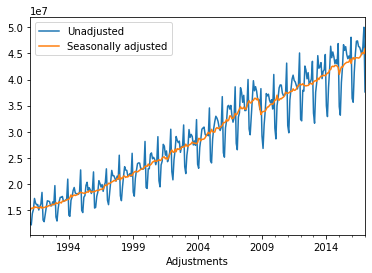

In [6]:
df.plot()

In [8]:
split_date = pd.Timestamp('01-01-2011')
#split_date

Timestamp('2011-01-01 00:00:00')

In [9]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

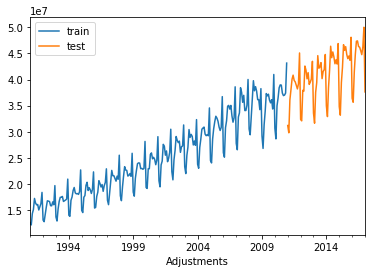

In [10]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [11]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [12]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [13]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [14]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [15]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [16]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
120/120 [==============================] - 0s 849us/step - loss: 0.1799
Epoch 2/200
120/120 [==============================] - 0s 741us/step - loss: 0.0372
Epoch 3/200
120/120 [==============================] - 0s 804us/step - loss: 0.0235
Epoch 4/200
120/120 [==============================] - 0s 807us/step - loss: 0.0198
Epoch 5/200
120/120 [==============================] - 0s 798us/step - loss: 0.0168
Epoch 6/200
120/120 [==============================] - 0s 672us/step - loss: 0.0147
Epoch 7/200
120/120 [==============================] - 0s 676us/step - loss: 0.0131
Epoch 8/200
120/120 [==============================] - 0s 767us/step - loss: 0.0119
Epoch 9/200
120/120 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 10/200
120/120 [==============================] - 0s 896us/step - loss: 0.0107
Epoch 11/200
120/120 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 12/200
120/120 [==============================] - 0s 681us/step - loss: 

In [17]:
y_pred = model.predict(X_test)

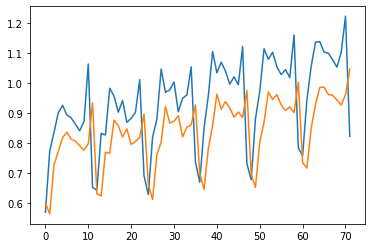

In [18]:
plt.plot(y_test)
plt.plot(y_pred)

In [19]:
from keras.layers import LSTM

In [20]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [22]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
239/239 [==============================] - 0s 1ms/step - loss: 0.0854
Epoch 2/100
239/239 [==============================] - 0s 1ms/step - loss: 0.0285
Epoch 3/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 4/100
239/239 [==============================] - 0s 1ms/step - loss: 0.0175
Epoch 5/100
239/239 [==============================] - 0s 1ms/step - loss: 0.0139
Epoch 6/100
239/239 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 7/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 8/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 9/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 10/100
239/239 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 00010: early stopping


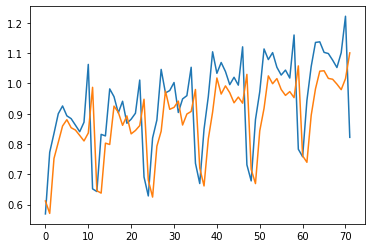

In [24]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

In [25]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [26]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [27]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [28]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [29]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/200
228/228 [==============================] - 0s 829us/step - loss: 0.1837
Epoch 2/200
228/228 [==============================] - 0s 845us/step - loss: 0.0163
Epoch 3/200
228/228 [==============================] - 0s 1ms/step - loss: 0.0134
Epoch 4/200
228/228 [==============================] - 0s 653us/step - loss: 0.0109
Epoch 5/200
228/228 [==============================] - 0s 701us/step - loss: 0.0093
Epoch 6/200
228/228 [==============================] - 0s 766us/step - loss: 0.0083
Epoch 7/200
228/228 [==============================] - 0s 619us/step - loss: 0.0075
Epoch 8/200
228/228 [==============================] - 0s 873us/step - loss: 0.0068
Epoch 9/200
228/228 [==============================] - 0s 958us/step - loss: 0.0060
Epoch 10/200
228/228 [==============================] - 0s 948us/step - loss: 0.0057
Epoch 11/200
228/228 [==============================] - 0s 790us/step - loss: 0.0049
Epoch 12/200
228/228 [==============================] - 0s 883us/step - loss

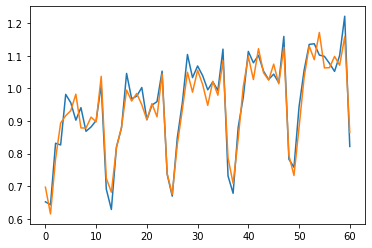

In [31]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

In [32]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [33]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 456       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 0s 1ms/step - loss: 0.0498
Epoch 2/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 3/100
228/228 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 4/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 5/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 6/100
228/228 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 7/100
228/228 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 8/100
228/228 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 9/100
228/228 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 10/100
228/228 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 11/100
228/228 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 12/100
228/228 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 13/100


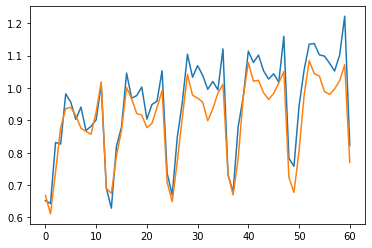

In [36]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)